# DAC Codebook Analysis: Clean vs Noisy

This notebook analyzes which codebooks in DAC 16kHz encode "clean" vs "noisy" information by creating hybrid code combinations.

In [108]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML
import os
import random
from pathlib import Path
import scipy.io.wavfile as wavfile

# Add parent directory to path for dac imports
import sys
sys.path.insert(0, '..')

import dac
from dac.utils import load_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [109]:
# Load DAC 16kHz model
model = load_model(model_type="16khz")
model = model.to(device)
model.eval()
print(f"Loaded DAC 16kHz model with {model.n_codebooks} codebooks")

Loaded DAC 16kHz model with 12 codebooks


In [110]:
# Load sample data - pick a random pair
sample_dir = Path("../sample_data")
clean_dir = sample_dir / "clean"
noise_dir = sample_dir / "noise"

# Get list of clean files
clean_files = list(clean_dir.glob("*.wav"))
random_clean = random.choice(clean_files)

# Find corresponding noisy file
base_name = random_clean.stem  # e.g., p249_290
noisy_file = list(noise_dir.glob(f"{base_name}*.wav"))[0]

print(f"Selected clean file: {random_clean.name}")
print(f"Selected noisy file: {noisy_file.name}")

Selected clean file: p333_331.wav
Selected noisy file: p333_331_confroom1_iPad_ch1.wav


In [111]:
# Load audio files
def load_audio(filepath, target_sr=16000):
    sr, audio = wavfile.read(filepath)
    # Convert to float32 and normalize
    if audio.dtype == np.int16:
        audio = audio.astype(np.float32) / 32768.0
    elif audio.dtype == np.int32:
        audio = audio.astype(np.float32) / 2147483648.0
    elif audio.dtype == np.float64:
        audio = audio.astype(np.float32)
    
    # Ensure mono
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1)
    
    return audio, sr

clean_audio, sr_clean = load_audio(random_clean)
noisy_audio, sr_noisy = load_audio(noisy_file)

print(f"Clean audio: {len(clean_audio)} samples, {sr_clean} Hz, duration: {len(clean_audio)/sr_clean:.2f}s")
print(f"Noisy audio: {len(noisy_audio)} samples, {sr_noisy} Hz, duration: {len(noisy_audio)/sr_noisy:.2f}s")

Clean audio: 38571 samples, 16000 Hz, duration: 2.41s
Noisy audio: 38571 samples, 16000 Hz, duration: 2.41s


In [112]:
# Make sure both audios have same length (use minimum)
min_len = min(len(clean_audio), len(noisy_audio))
clean_audio = clean_audio[:min_len]
noisy_audio = noisy_audio[:min_len]

print(f"Aligned length: {min_len} samples ({min_len/16000:.2f}s)")

Aligned length: 38571 samples (2.41s)


ORIGINAL CLEAN AUDIO


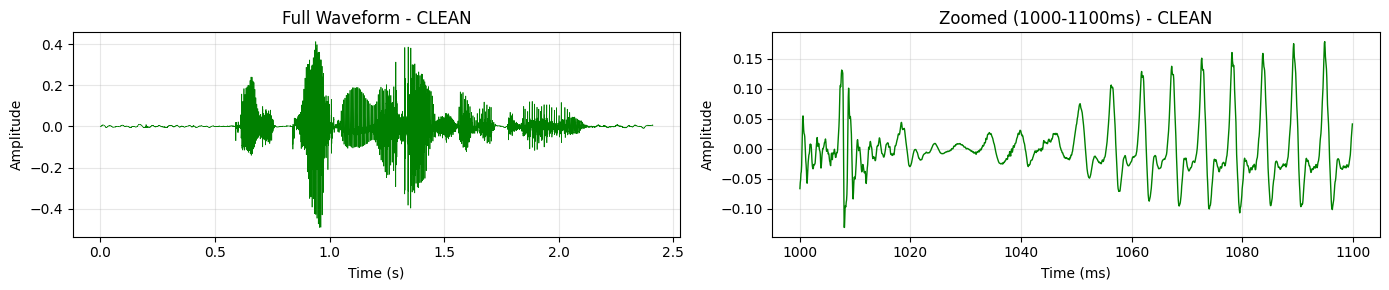


ORIGINAL NOISY AUDIO


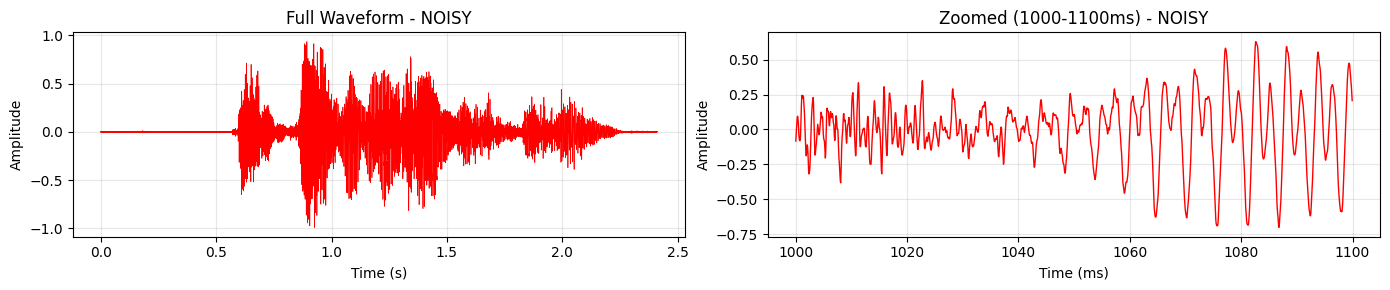

In [113]:
# Original Clean and Noisy Audio with Waveforms

# === CLEAN AUDIO ===
print("=" * 60)
print("ORIGINAL CLEAN AUDIO")
print("=" * 60)
display(Audio(clean_audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Full waveform - Clean
time_full = np.arange(len(clean_audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Full Waveform - CLEAN')
axes[0].grid(True, alpha=0.3)

# Zoomed waveform - Clean (100ms starting from 1 second = 1600 samples at 16kHz)
zoom_start = 16000  # 1 second
zoom_samples = 1600  # 100ms
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000  # Convert to ms, offset by 1000ms
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Zoomed (1000-1100ms) - CLEAN')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === NOISY AUDIO ===
print("\n" + "=" * 60)
print("ORIGINAL NOISY AUDIO")
print("=" * 60)
display(Audio(noisy_audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Full waveform - Noisy
time_full = np.arange(len(noisy_audio)) / 16000
axes[0].plot(time_full, noisy_audio, linewidth=0.5, color='red')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Full Waveform - NOISY')
axes[0].grid(True, alpha=0.3)

# Zoomed waveform - Noisy
axes[1].plot(time_zoom, noisy_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='red')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Zoomed (1000-1100ms) - NOISY')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [114]:
# Encode both audios with DAC
def encode_audio(model, audio, device):
    """Encode audio and return codes"""
    # Prepare input: [B, 1, T]
    audio_tensor = torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0).to(device)
    
    # Preprocess (padding)
    audio_tensor = model.preprocess(audio_tensor, sample_rate=16000)
    
    with torch.no_grad():
        z, codes, latents, _, _ = model.encode(audio_tensor)
    
    return codes, z

clean_codes, clean_z = encode_audio(model, clean_audio, device)
noisy_codes, noisy_z = encode_audio(model, noisy_audio, device)

print(f"Clean codes shape: {clean_codes.shape}")
print(f"Noisy codes shape: {noisy_codes.shape}")
print(f"\nCodes shape is [batch, n_codebooks, time_steps]")
print(f"Number of codebooks: {clean_codes.shape[1]}")
print(f"Number of time steps: {clean_codes.shape[2]}")

Clean codes shape: torch.Size([1, 12, 121])
Noisy codes shape: torch.Size([1, 12, 121])

Codes shape is [batch, n_codebooks, time_steps]
Number of codebooks: 12
Number of time steps: 121


In [115]:
# Function to create hybrid codes and decode
def create_hybrid_and_decode(model, clean_codes, noisy_codes, n_clean_codebooks, device):
    """
    Create hybrid codes where first n_clean_codebooks are from clean,
    and the rest are from noisy.
    
    n_clean_codebooks: 1 to 12
    - 1 means: [C, N, N, N, N, N, N, N, N, N, N, N]
    - 12 means: [C, C, C, C, C, C, C, C, C, C, C, N] (11 clean, 1 noisy)
    """
    n_codebooks = clean_codes.shape[1]
    
    # Create hybrid codes
    hybrid_codes = torch.zeros_like(clean_codes)
    
    # First n_clean_codebooks from clean
    hybrid_codes[:, :n_clean_codebooks, :] = clean_codes[:, :n_clean_codebooks, :]
    
    # Rest from noisy
    hybrid_codes[:, n_clean_codebooks:, :] = noisy_codes[:, n_clean_codebooks:, :]
    
    # Decode using quantizer.from_codes
    with torch.no_grad():
        z_q, _, _ = model.quantizer.from_codes(hybrid_codes)
        decoded_audio = model.decode(z_q)
    
    return decoded_audio.squeeze().cpu().numpy(), hybrid_codes

# Test with one hybrid
test_audio, test_codes = create_hybrid_and_decode(model, clean_codes, noisy_codes, 1, device)
print(f"Decoded audio shape: {test_audio.shape}")

Decoded audio shape: (38712,)


In [116]:
# Generate all 12 hybrid waveforms
n_codebooks = clean_codes.shape[1]
hybrid_audios = []

for n_clean in range(1, n_codebooks + 1):
    audio, codes = create_hybrid_and_decode(model, clean_codes, noisy_codes, n_clean, device)
    hybrid_audios.append(audio)
    
    # Create label showing which codebooks are clean (C) vs noisy (N)
    label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
    print(f"Hybrid {n_clean:2d}: {' '.join(label)}")

print(f"\nGenerated {len(hybrid_audios)} hybrid waveforms")

# Helper function to calculate metrics
def calculate_metrics(clean, generated):
    """Calculate MSE, SNR, and correlation between clean and generated audio"""
    # Ensure same length
    min_len = min(len(clean), len(generated))
    clean = clean[:min_len]
    generated = generated[:min_len]
    
    # MSE
    mse = np.mean((clean - generated) ** 2)
    
    # SNR (Signal-to-Noise Ratio in dB)
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - generated) ** 2)
    if noise_power > 0:
        snr = 10 * np.log10(signal_power / noise_power)
    else:
        snr = float('inf')
    
    # Correlation
    corr = np.corrcoef(clean, generated)[0, 1]
    
    return mse, snr, corr

print("\n" + "=" * 60)
print("Reference: Metrics for Original Noisy vs Clean")
print("=" * 60)
mse_noisy, snr_noisy, corr_noisy = calculate_metrics(clean_audio, noisy_audio)
print(f"MSE: {mse_noisy:.6f} | SNR: {snr_noisy:.2f} dB | Correlation: {corr_noisy:.4f}")

Hybrid  1: C N N N N N N N N N N N
Hybrid  2: C C N N N N N N N N N N
Hybrid  3: C C C N N N N N N N N N
Hybrid  4: C C C C N N N N N N N N
Hybrid  5: C C C C C N N N N N N N
Hybrid  6: C C C C C C N N N N N N
Hybrid  7: C C C C C C C N N N N N
Hybrid  8: C C C C C C C C N N N N
Hybrid  9: C C C C C C C C C N N N
Hybrid 10: C C C C C C C C C C N N
Hybrid 11: C C C C C C C C C C C N
Hybrid 12: C C C C C C C C C C C C

Generated 12 hybrid waveforms

Reference: Metrics for Original Noisy vs Clean
MSE: 0.024748 | SNR: -10.30 dB | Correlation: 0.2879


---
## Hybrid Waveform Analysis

Below are 12 cells, each showing:
1. Audio player
2. Full waveform plot
3. Zoomed waveform (first 20ms)

**Pattern**: Hybrid N has first N codebooks from CLEAN, rest from NOISY

Hybrid 1: C N N N N N N N N N N N
MSE: 0.009264 | SNR: -6.03 dB | Correlation: 0.0134


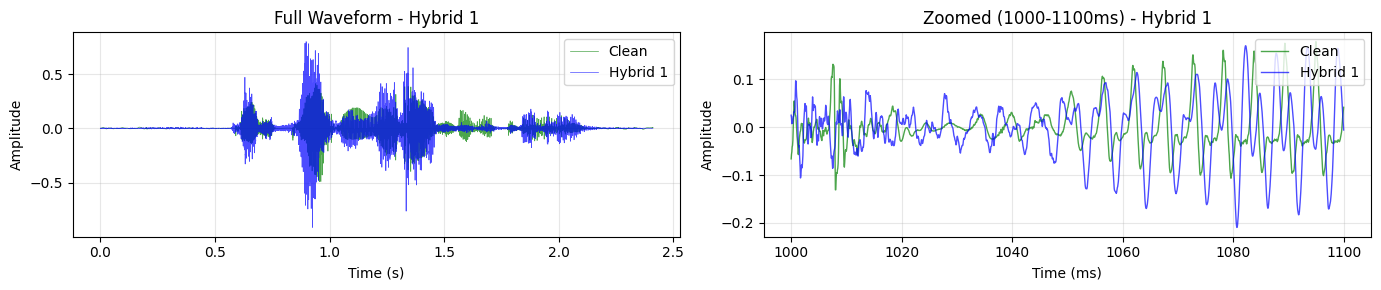

In [117]:
# Hybrid 1: [C, N, N, N, N, N, N, N, N, N, N, N] - 1 clean, 11 noisy
idx = 0
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]  # Trim to original length

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Full waveform
time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Zoomed waveform (100ms from 1 second mark)
zoom_start = 16000  # 1 second
zoom_samples = 1600  # 100ms
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000  # ms
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 2: C C N N N N N N N N N N
MSE: 0.006534 | SNR: -4.52 dB | Correlation: -0.0504


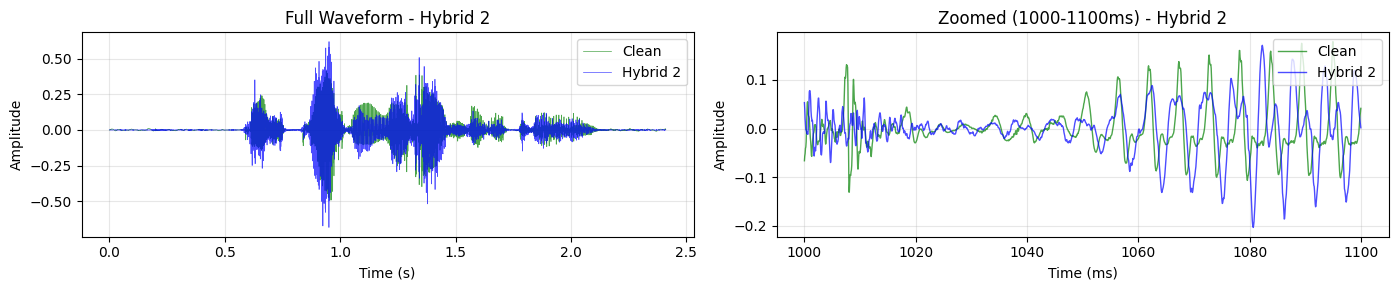

In [118]:
# Hybrid 2: [C, C, N, N, N, N, N, N, N, N, N, N] - 2 clean, 10 noisy
idx = 1
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 3: C C C N N N N N N N N N
MSE: 0.004822 | SNR: -3.20 dB | Correlation: -0.0417


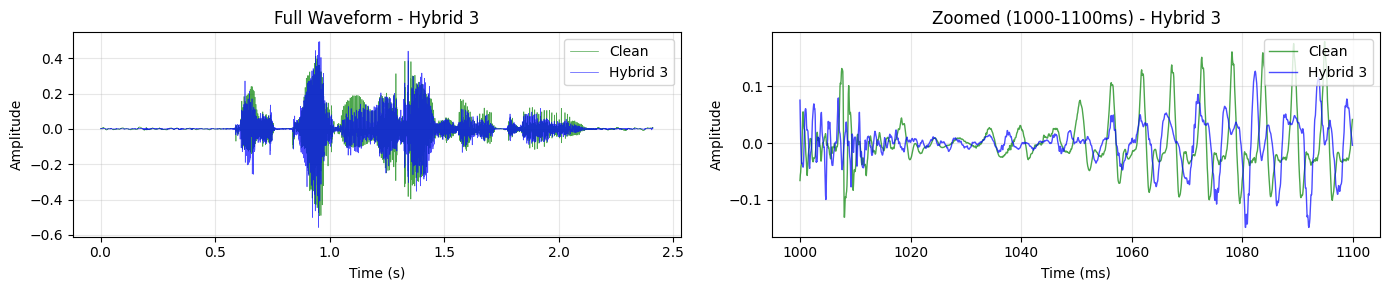

In [119]:
# Hybrid 3: [C, C, C, N, N, N, N, N, N, N, N, N] - 3 clean, 9 noisy
idx = 2
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 4: C C C C N N N N N N N N
MSE: 0.004700 | SNR: -3.09 dB | Correlation: -0.0591


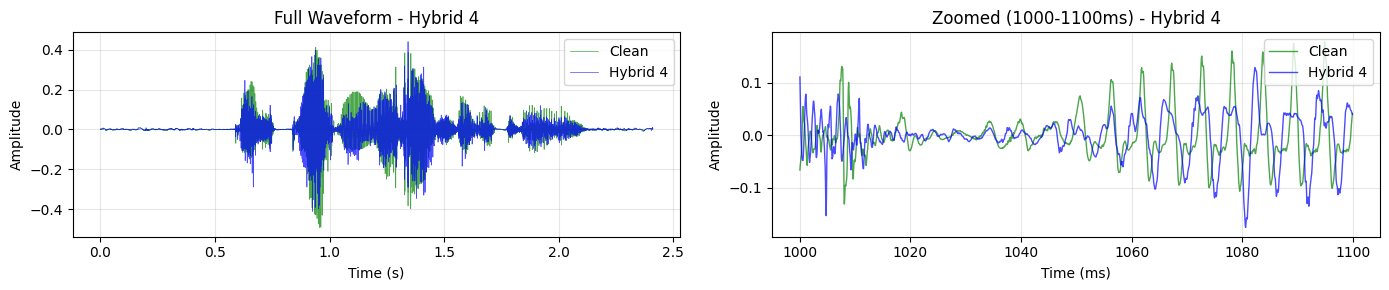

In [120]:
# Hybrid 4: [C, C, C, C, N, N, N, N, N, N, N, N] - 4 clean, 8 noisy
idx = 3
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 5: C C C C C N N N N N N N
MSE: 0.004671 | SNR: -3.06 dB | Correlation: -0.0891


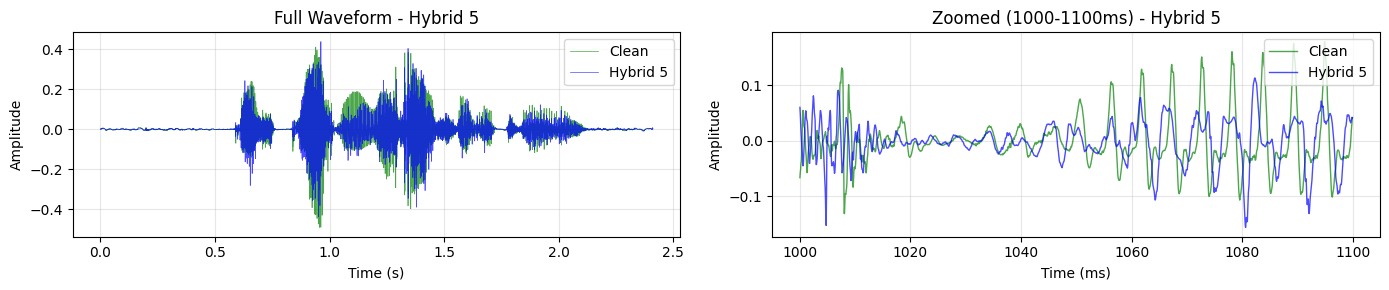

In [121]:
# Hybrid 5: [C, C, C, C, C, N, N, N, N, N, N, N] - 5 clean, 7 noisy
idx = 4
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 6: C C C C C C N N N N N N
MSE: 0.004560 | SNR: -2.96 dB | Correlation: -0.0792


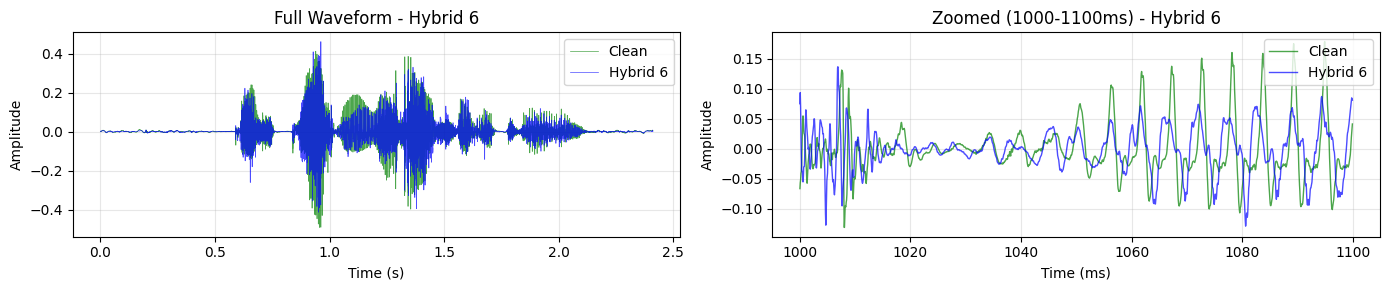

In [122]:
# Hybrid 6: [C, C, C, C, C, C, N, N, N, N, N, N] - 6 clean, 6 noisy
idx = 5
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 7: C C C C C C C N N N N N
MSE: 0.004715 | SNR: -3.10 dB | Correlation: -0.0941


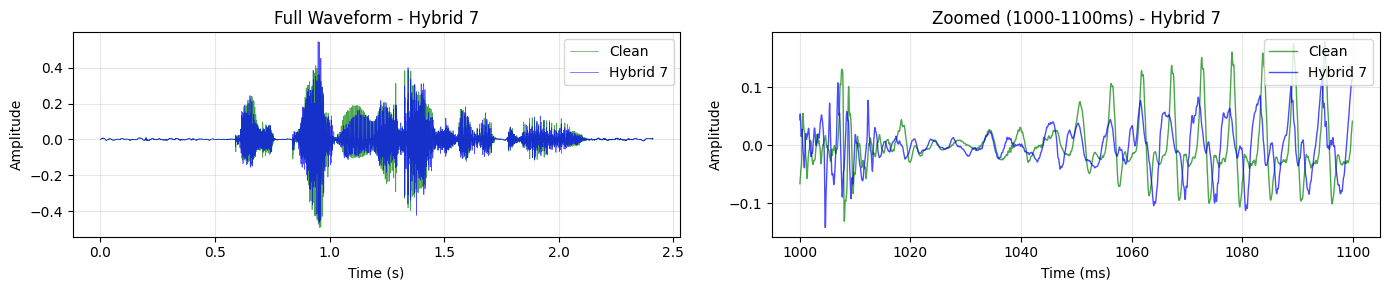

In [123]:
# Hybrid 7: [C, C, C, C, C, C, C, N, N, N, N, N] - 7 clean, 5 noisy
idx = 6
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 8: C C C C C C C C N N N N
MSE: 0.005089 | SNR: -3.43 dB | Correlation: -0.1412


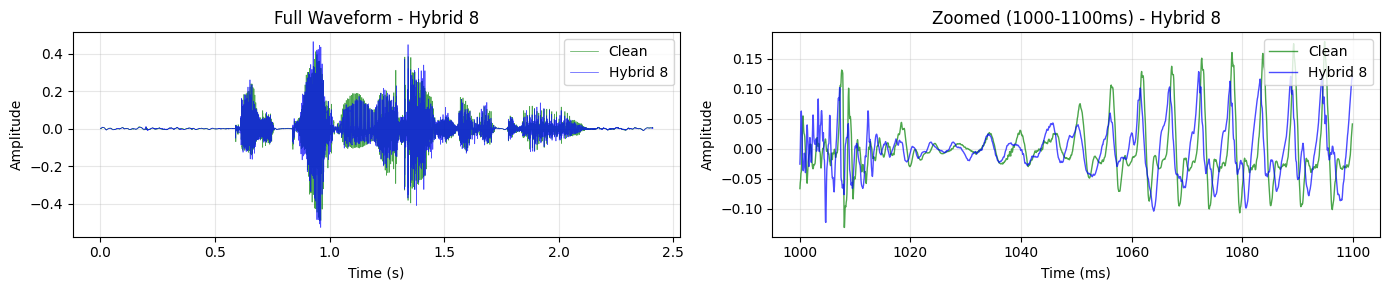

In [124]:
# Hybrid 8: [C, C, C, C, C, C, C, C, N, N, N, N] - 8 clean, 4 noisy
idx = 7
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 9: C C C C C C C C C N N N
MSE: 0.005206 | SNR: -3.53 dB | Correlation: -0.1353


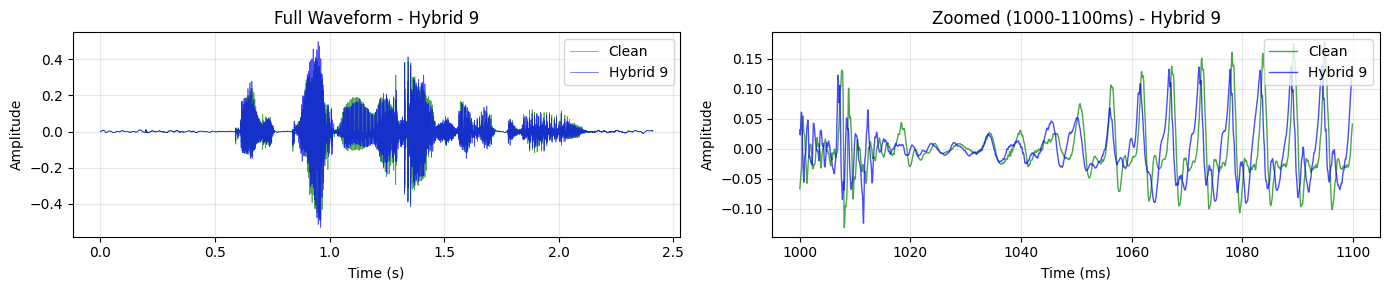

In [125]:
# Hybrid 9: [C, C, C, C, C, C, C, C, C, N, N, N] - 9 clean, 3 noisy
idx = 8
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 10: C C C C C C C C C C N N
MSE: 0.005204 | SNR: -3.53 dB | Correlation: -0.1394


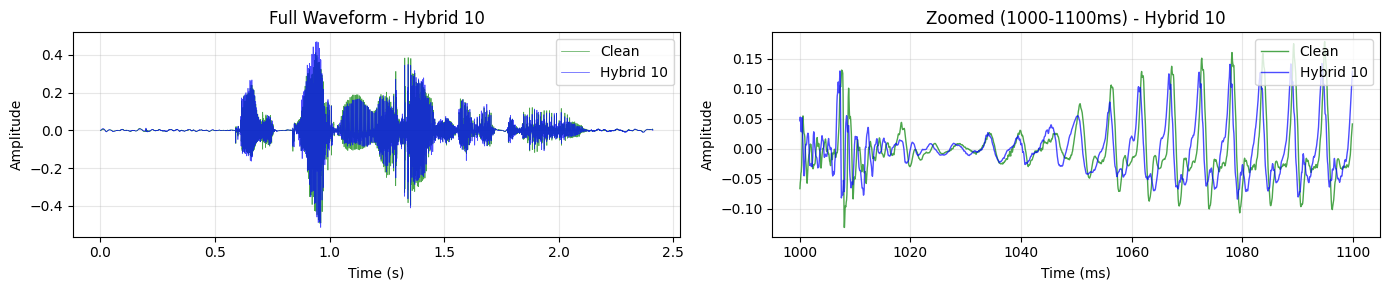

In [126]:
# Hybrid 10: [C, C, C, C, C, C, C, C, C, C, N, N] - 10 clean, 2 noisy
idx = 9
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 11: C C C C C C C C C C C N
MSE: 0.005266 | SNR: -3.58 dB | Correlation: -0.1553


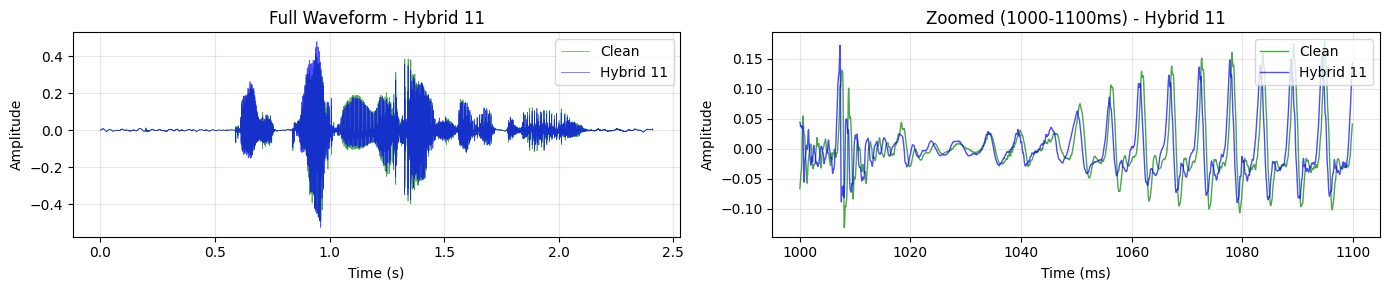

In [127]:
# Hybrid 11: [C, C, C, C, C, C, C, C, C, C, C, N] - 11 clean, 1 noisy
idx = 10
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 12: C C C C C C C C C C C C (Fully Clean Reconstruction)
MSE: 0.005351 | SNR: -3.65 dB | Correlation: -0.1529


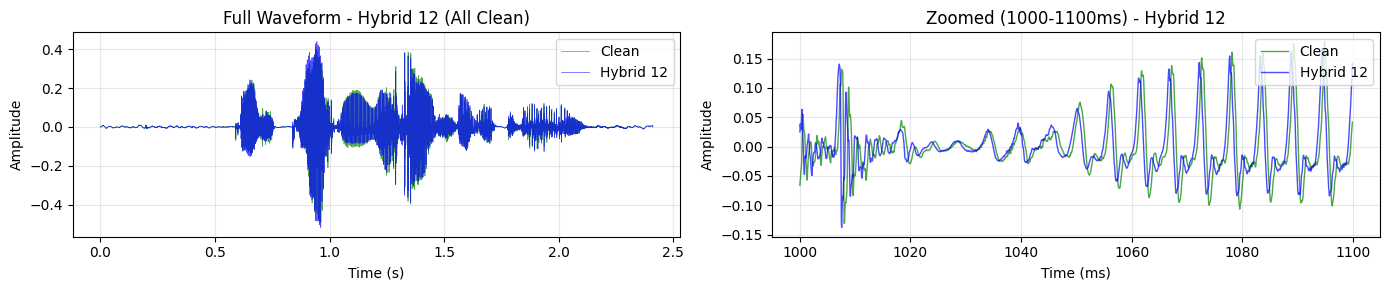

In [128]:
# Hybrid 12: [C, C, C, C, C, C, C, C, C, C, C, C] - 12 clean, 0 noisy (fully clean reconstruction)
idx = 11
n_clean = idx + 1
label = ['C'] * n_clean + ['N'] * (n_codebooks - n_clean)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_clean}: {' '.join(label)} (Fully Clean Reconstruction)")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_clean} (All Clean)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_clean}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_clean}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [129]:
# Generate metrics JSON for all 5 files x 12 variants x 3 metrics
import json

# Get all clean files
all_clean_files = sorted(list(clean_dir.glob("*.wav")))
print(f"Found {len(all_clean_files)} clean files")

results = {
    "files": [],
    "metrics": ["mse", "snr", "correlation"],
    "n_variants": 12,
    "data": []  # Shape: [n_files, 12, 3]
}

for file_idx, clean_file in enumerate(all_clean_files):
    base_name = clean_file.stem
    noisy_file = list(noise_dir.glob(f"{base_name}*.wav"))[0]
    
    print(f"\nProcessing file {file_idx + 1}/5: {base_name}")
    results["files"].append(base_name)
    
    # Load audio
    clean_aud, _ = load_audio(clean_file)
    noisy_aud, _ = load_audio(noisy_file)
    
    # Align lengths
    min_length = min(len(clean_aud), len(noisy_aud))
    clean_aud = clean_aud[:min_length]
    noisy_aud = noisy_aud[:min_length]
    
    # Encode both
    clean_c, _ = encode_audio(model, clean_aud, device)
    noisy_c, _ = encode_audio(model, noisy_aud, device)
    
    # Generate 12 variants and calculate metrics
    file_metrics = []  # [12, 3]
    
    for n_clean in range(1, 13):
        hybrid_aud, _ = create_hybrid_and_decode(model, clean_c, noisy_c, n_clean, device)
        hybrid_aud = hybrid_aud[:min_length]
        
        mse, snr, corr = calculate_metrics(clean_aud, hybrid_aud)
        file_metrics.append([float(mse), float(snr), float(corr)])
        
        label = ['C'] * n_clean + ['N'] * (12 - n_clean)
        print(f"  Variant {n_clean:2d} ({' '.join(label)}): MSE={mse:.6f}, SNR={snr:.2f}dB, Corr={corr:.4f}")
    
    results["data"].append(file_metrics)

# Convert to the exact shape requested: [5, 12, 3]
print(f"\n{'='*60}")
print(f"Results shape: [{len(results['data'])}, {len(results['data'][0])}, {len(results['data'][0][0])}]")
print(f"Files: {results['files']}")
print(f"Metrics order: {results['metrics']}")

# Save to JSON file
json_output_path = "../sample_data/codebook_metrics.json"
with open(json_output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nJSON saved to: {json_output_path}")

# Also display the JSON
print(f"\n{'='*60}")
print("JSON Output:")
print(json.dumps(results, indent=2))

Found 5 clean files

Processing file 1/5: p249_290
  Variant  1 (C N N N N N N N N N N N): MSE=0.011657, SNR=-3.81dB, Corr=0.3305
  Variant  2 (C C N N N N N N N N N N): MSE=0.008477, SNR=-2.42dB, Corr=0.3171
  Variant  3 (C C C N N N N N N N N N): MSE=0.007601, SNR=-1.95dB, Corr=0.3133
  Variant  4 (C C C C N N N N N N N N): MSE=0.007240, SNR=-1.74dB, Corr=0.3111
  Variant  5 (C C C C C N N N N N N N): MSE=0.007079, SNR=-1.64dB, Corr=0.3042
  Variant  6 (C C C C C C N N N N N N): MSE=0.006914, SNR=-1.54dB, Corr=0.2922
  Variant  7 (C C C C C C C N N N N N): MSE=0.006759, SNR=-1.44dB, Corr=0.3153
  Variant  8 (C C C C C C C C N N N N): MSE=0.006703, SNR=-1.40dB, Corr=0.3161
  Variant  9 (C C C C C C C C C N N N): MSE=0.006735, SNR=-1.42dB, Corr=0.3137
  Variant 10 (C C C C C C C C C C N N): MSE=0.006831, SNR=-1.49dB, Corr=0.2956
  Variant 11 (C C C C C C C C C C C N): MSE=0.006693, SNR=-1.40dB, Corr=0.2992
  Variant 12 (C C C C C C C C C C C C): MSE=0.006950, SNR=-1.56dB, Corr=0.2746



  Variant  1 (C N N N N N N N N N N N): MSE=0.009264, SNR=-6.03dB, Corr=0.0134
  Variant  2 (C C N N N N N N N N N N): MSE=0.006534, SNR=-4.52dB, Corr=-0.0504
  Variant  3 (C C C N N N N N N N N N): MSE=0.004822, SNR=-3.20dB, Corr=-0.0417
  Variant  4 (C C C C N N N N N N N N): MSE=0.004700, SNR=-3.09dB, Corr=-0.0591
  Variant  5 (C C C C C N N N N N N N): MSE=0.004671, SNR=-3.06dB, Corr=-0.0891
  Variant  6 (C C C C C C N N N N N N): MSE=0.004560, SNR=-2.96dB, Corr=-0.0792
  Variant  7 (C C C C C C C N N N N N): MSE=0.004715, SNR=-3.10dB, Corr=-0.0941
  Variant  8 (C C C C C C C C N N N N): MSE=0.005089, SNR=-3.43dB, Corr=-0.1412
  Variant  9 (C C C C C C C C C N N N): MSE=0.005206, SNR=-3.53dB, Corr=-0.1353
  Variant 10 (C C C C C C C C C C N N): MSE=0.005204, SNR=-3.53dB, Corr=-0.1394
  Variant 11 (C C C C C C C C C C C N): MSE=0.005266, SNR=-3.58dB, Corr=-0.1553
  Variant 12 (C C C C C C C C C C C C): MSE=0.005351, SNR=-3.65dB, Corr=-0.1529

Processing file 4/5: p336_136
  Variant 